<center><h1>Stock Price forecasting</h1></center>
<a href="https://www.tensorflow.org/tutorials/structured_data/time_series" style="color:black;font-size:15px;" ><strong>Tutorial</strong>></a>

In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
# zip_path = tf.keras.utils.get_file(
#     origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
#     fname='jena_climate_2009_2016.csv.zip',
#     extract=True)
# csv_path, _ = os.path.splitext(zip_path)
csv_path = 'Trading/csvs/NSE-TATAGLOBAL.csv'

In [14]:
df = pd.read_csv(csv_path)
df = df.iloc[::-1]  # original df is from 2018 - 2010. To reverse the date this step is used
df.head(10)


,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
2034,2010-07-21,122.1,123.00,121.05,121.10,121.55,658666,803.56
2033,2010-07-22,120.3,122.00,120.25,120.75,120.90,293312,355.17
2032,2010-07-23,121.8,121.95,120.25,120.35,120.65,281312,340.31
2031,2010-07-26,120.1,121.00,117.10,117.10,117.60,658440,780.01
2030,2010-07-27,117.6,119.50,112.00,118.80,118.65,586100,694.98
2029,2010-07-28,118.0,120.50,117.20,118.15,118.25,835593,994.01
2028,2010-07-29,112.5,121.70,112.50,117.50,116.60,2359134,2791.03
2027,2010-07-30,116.5,118.00,114.60,115.85,116.05,2656191,3112.68
2026,2010-08-02,117.3,118.50,116.60,118.10,117.30,663593,779.85
2025,2010-08-03,118.3,119.95,117.90,118.65,118.30,611234,726.78


In [15]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [23]:
TRAIN_SPLIT = 1500
tf.random.set_seed(13)

In [24]:
uni_data = df['Close']
uni_data.index = df['Date']
uni_data.head()

Date
2010-07-21    121.55
2010-07-22    120.90
2010-07-23    120.65
2010-07-26    117.60
2010-07-27    118.65
Name: Close, dtype: float64

/home/ash/Ash/venvTF2/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


array([<AxesSubplot:xlabel='Date'>], dtype=object)

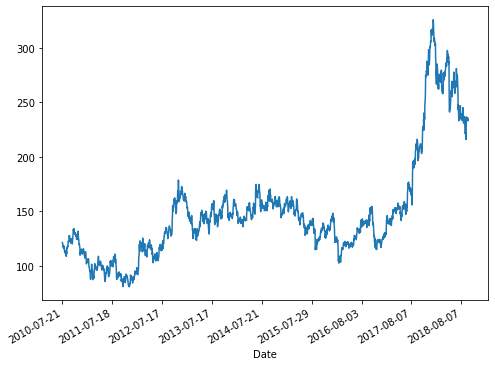

In [25]:
uni_data.plot(subplots=True)

In [26]:
uni_data = uni_data.values
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [28]:
univariate_past_history = 10
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target price to predict')
print (y_train_uni[0])

Single window of past history
[[-0.40352255]
 [-0.43199907]
 [-0.44295158]
 [-0.57657219]
 [-0.53057165]
 [-0.54809566]
 [-0.62038222]
 [-0.64447774]
 [-0.5897152 ]
 [-0.54590516]]

 Target price to predict
-0.6247632256018866


In [29]:
def create_time_steps(length):
    return list(range(-length, 0))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from '/home/ash/Ash/venvTF2/lib/python3.6/site-packages/matplotlib/pyplot.py'>

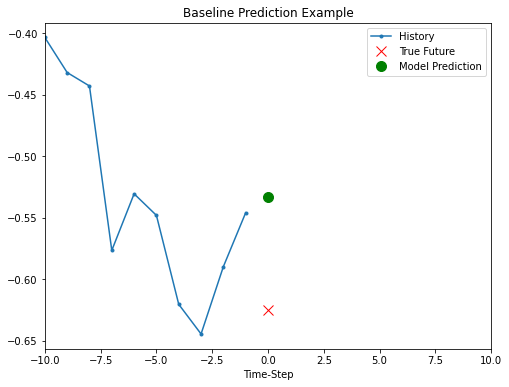

In [30]:
# show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')
def baseline(history):
    return np.mean(history)

show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

## Recurrent Neural Networks

In [31]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()
train_univariate, val_univariate

(<RepeatDataset shapes: ((None, 10, 1), (None,)), types: (tf.float64, tf.float64)>,
 <RepeatDataset shapes: ((None, 10, 1), (None,)), types: (tf.float64, tf.float64)>)

In [32]:
x_train_uni.shape[-2:], x_train_uni.shape

((10, 1), (1490, 10, 1))

In [33]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)


(256, 1)


In [34]:
EVALUATION_INTERVAL = 100
EPOCHS = 10

In [35]:
simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
100/100 [==============================] - 1s 9ms/step - loss: 0.5411 - val_loss: 2.7764
Epoch 2/10
100/100 [==============================] - 1s 6ms/step - loss: 0.2672 - val_loss: 2.7824
Epoch 3/10
100/100 [==============================] - 1s 7ms/step - loss: 0.1690 - val_loss: 2.5685
Epoch 4/10
100/100 [==============================] - 1s 6ms/step - loss: 0.1355 - val_loss: 2.2796
Epoch 5/10
100/100 [==============================] - 1s 6ms/step - loss: 0.1184 - val_loss: 2.0514
Epoch 6/10
100/100 [==============================] - 1s 6ms/step - loss: 0.1064 - val_loss: 1.9335
Epoch 7/10
100/100 [==============================] - 1s 6ms/step - loss: 0.0991 - val_loss: 1.8633
Epoch 8/10
100/100 [==============================] - 1s 6ms/step - loss: 0.0939 - val_loss: 1.8122
Epoch 9/10
100/100 [==============================] - 1s 6ms/step - loss: 0.0904 - val_loss: 1.7764
Epoch 10/10
100/100 [==============================] - 1s 6ms/step - loss: 0.0884 - val_loss: 1.7552

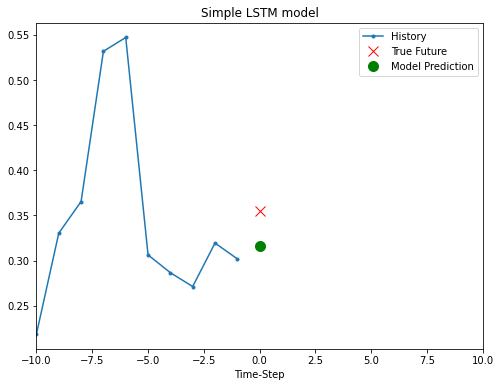

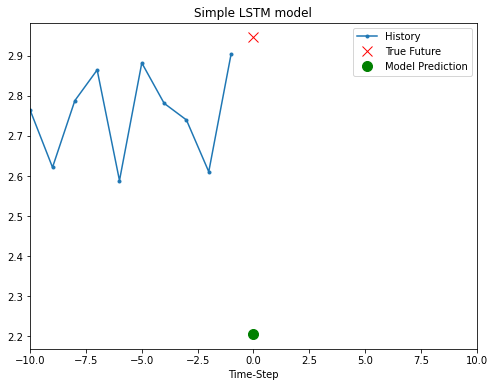

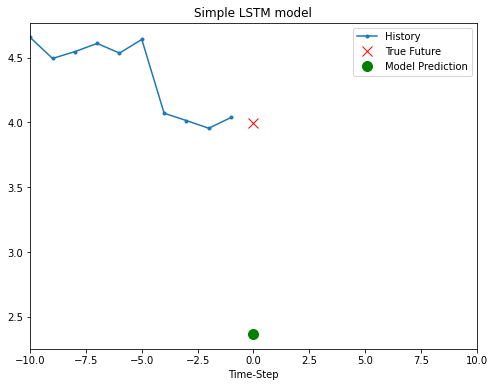

In [36]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()


## Multivariate time series

In [45]:
features_considered = ['High', 'Low', 'Close']

features = df[features_considered]
features.index = df['Date']
features.head()

,High,Low,Close
Date,,,
2010-07-21,123.00,121.05,121.55
2010-07-22,122.00,120.25,120.90
2010-07-23,121.95,120.25,120.65
2010-07-26,121.00,117.10,117.60
2010-07-27,119.50,112.00,118.65


/home/ash/Ash/venvTF2/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>], dtype=object)

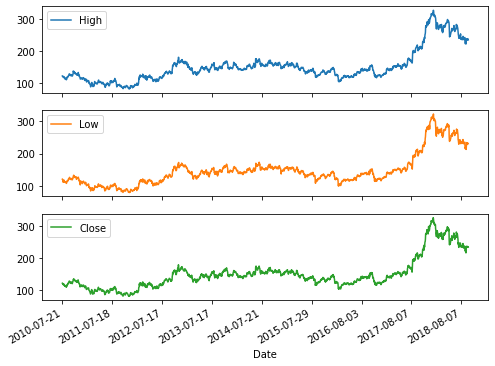

In [46]:
features.plot(subplots=True)

In [47]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

dataset = (dataset-data_mean)/data_std

### Single step model

In [48]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)


In [65]:
past_history = 300
future_target = 30
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)
print ('Single window of past history : {}'.format(x_train_single[0].shape))


Single window of past history : (50, 3)


In [66]:
x_train_single.shape

(1200, 50, 3)

In [67]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(16,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

(205, 1)


In [68]:
val_data_single

<RepeatDataset shapes: ((None, 50, 3), (None,)), types: (tf.float64, tf.float64)>

In [69]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
100/100 [==============================] - 3s 26ms/step - loss: 0.4368 - val_loss: 4.7377
Epoch 2/10
100/100 [==============================] - 2s 23ms/step - loss: 0.3746 - val_loss: 4.7026
Epoch 3/10
100/100 [==============================] - 2s 23ms/step - loss: 0.3464 - val_loss: 5.1508
Epoch 4/10
100/100 [==============================] - 2s 23ms/step - loss: 0.3066 - val_loss: 5.3742
Epoch 5/10
100/100 [==============================] - 2s 24ms/step - loss: 0.2845 - val_loss: 5.4790
Epoch 6/10
100/100 [==============================] - 3s 25ms/step - loss: 0.2708 - val_loss: 5.4962
Epoch 7/10
100/100 [==============================] - 2s 23ms/step - loss: 0.2551 - val_loss: 5.4664
Epoch 8/10
100/100 [==============================] - 2s 24ms/step - loss: 0.2379 - val_loss: 5.4735
Epoch 9/10
100/100 [==============================] - 2s 24ms/step - loss: 0.2264 - val_loss: 5.4636
Epoch 10/10
100/100 [==============================] - 2s 23ms/step - loss: 0.2185 - val_lo

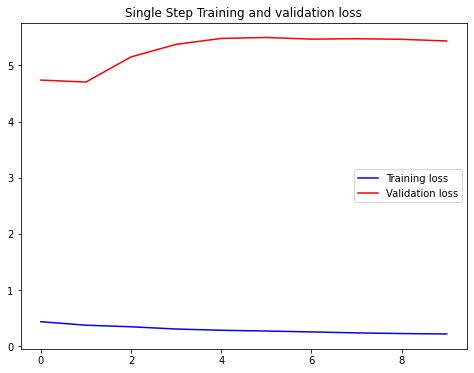

In [70]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

plot_train_history(single_step_history,
                   'Single Step Training and validation loss')


### Predict a single step future

(50, 3) (205,)


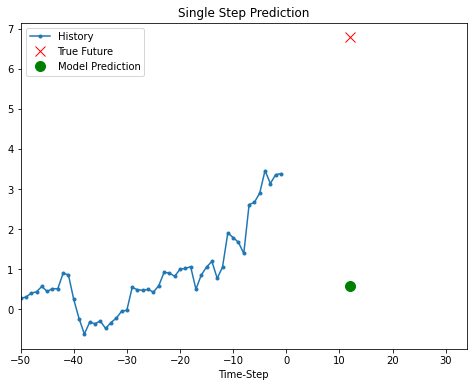

(50, 3) (205,)


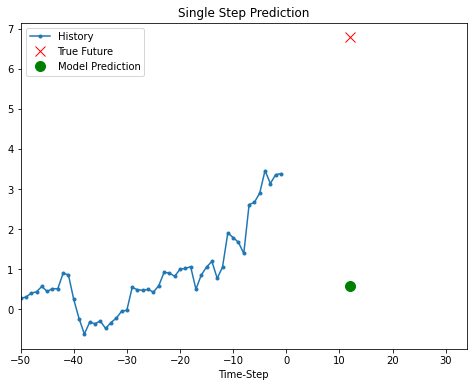

(50, 3) (205,)


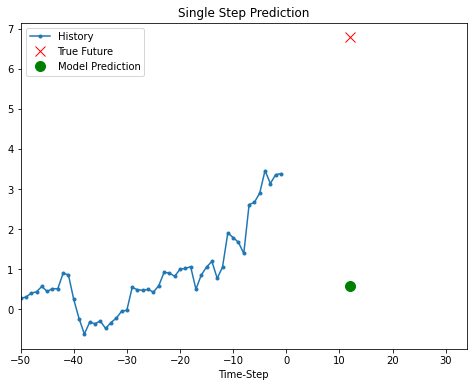

In [71]:
for x, y in val_data_single.take(3):
    print(x[0].shape, y.shape)
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
    plot.show()

### Multi-Step model

In [72]:
future_target = 88
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))


Single window of past history : (50, 3)

 Target temperature to predict : (88,)


In [73]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

(50, 3) (88,)


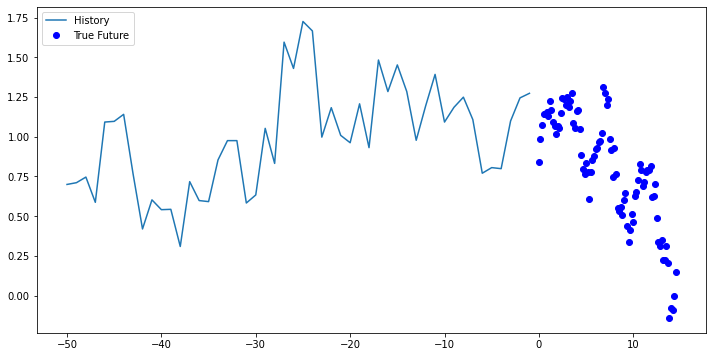

In [74]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

for x, y in train_data_multi.take(1):
    print(x[0].shape, y[0].shape)
    multi_step_plot(x[0], y[0], np.array([0]))

In [77]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(88))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

for x, y in val_data_multi.take(1):
    print (multi_step_model.predict(x).shape)


(147, 88)


Epoch 1/10
100/100 [==============================] - 5s 55ms/step - loss: 0.5453 - val_loss: 3.5117
Epoch 2/10
100/100 [==============================] - 5s 51ms/step - loss: 0.3509 - val_loss: 3.3294
Epoch 3/10
100/100 [==============================] - 5s 52ms/step - loss: 0.2892 - val_loss: 2.6854
Epoch 4/10
100/100 [==============================] - 5s 52ms/step - loss: 0.2596 - val_loss: 2.5127
Epoch 5/10
100/100 [==============================] - 5s 54ms/step - loss: 0.2425 - val_loss: 2.0177
Epoch 6/10
100/100 [==============================] - 6s 58ms/step - loss: 0.2324 - val_loss: 2.1475
Epoch 7/10
100/100 [==============================] - 7s 67ms/step - loss: 0.2251 - val_loss: 2.0955
Epoch 8/10
100/100 [==============================] - 6s 56ms/step - loss: 0.2185 - val_loss: 2.1620
Epoch 9/10
100/100 [==============================] - 5s 53ms/step - loss: 0.2128 - val_loss: 2.1041
Epoch 10/10
100/100 [==============================] - 5s 53ms/step - loss: 0.2080 - val_lo

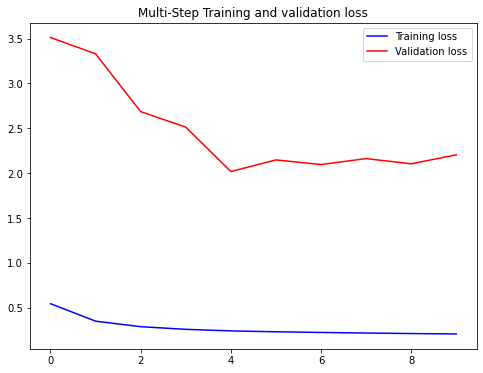

In [78]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')


### Predict a multi-step future

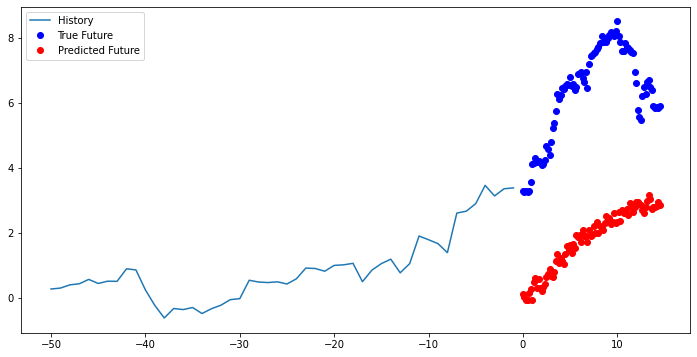

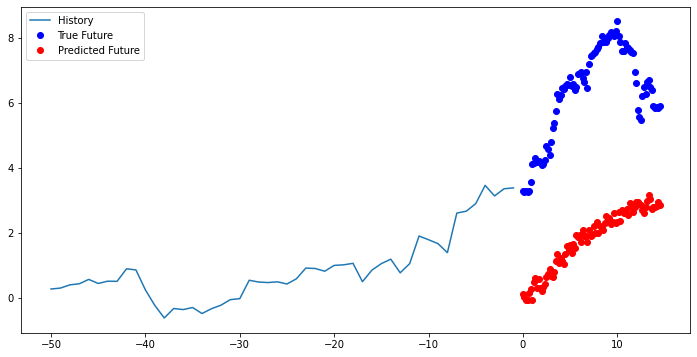

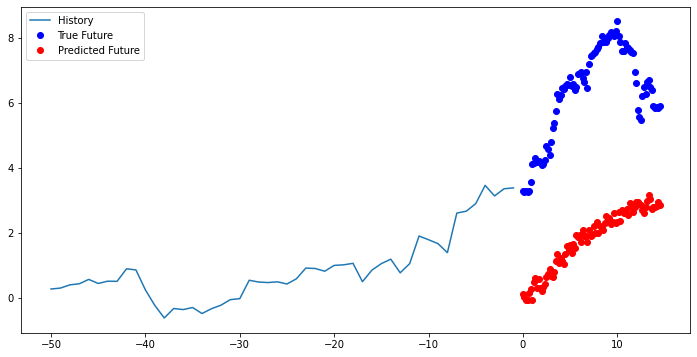

In [79]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])
